In [1]:
import os

import tensorflow.compat.v1 as tf
from nn_regressors import CNN, RNN, benchmark_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import numpy as np


/Users/brian/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/brian/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/brian/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/brian/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
def clear_saved_regressors():
    to_delete = [
        "cnn_cpu.joblib",
        "cnn_mem.joblib",
        "rnn_cpu.joblib",
        "rnn_mem.joblib",
    ]
    for file in to_delete:
        if os.path.exists(file):
            os.remove(file)

In [3]:
clear_saved_regressors()

In [4]:
cnn_cpu_reg = CNN.CPURegressor()
cnn_mem_reg = CNN.MemoryRegressor()

In [5]:
# Instantiate example models.
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=True, weights="imagenet",
)
resnet = tf.keras.applications.resnet50.ResNet50(include_top=True, weights="imagenet",)
densenet = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights="imagenet",
)
xception = tf.keras.applications.xception.Xception(
    include_top=True, weights="imagenet",
)
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=True, weights="imagenet",)

inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True, weights="imagenet",
)

models = [mobilenet, resnet, densenet, xception, vgg16, inception]
for model in models:
    cnn_cpu_reg.add_model_data(model)
    cnn_mem_reg.add_model_data(model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# Fit regressors to new model data.
cnn_cpu_reg.fit(model=SVR())  # Fit an SvR model
cnn_mem_reg.fit()  # default to Random Forest

(     units  filters  kernel_size  activation_linear  activation_softmax  \
 63    -1.0     -1.0         -1.0                0.0                 0.0   
 66    -1.0     -1.0         -1.0                0.0                -1.0   
 173   -1.0     -1.0         -1.0                0.0                -1.0   
 321   -1.0     -1.0         -1.0                0.0                -1.0   
 168   -1.0    512.0          9.0                1.0                 0.0   
 178   -1.0    128.0          1.0                1.0                -1.0   
 111   -1.0     -1.0         -1.0                0.0                -1.0   
 108   -1.0    576.0          1.0                1.0                 0.0   
 403   -1.0     -1.0         -1.0                0.0                -1.0   
 15    -1.0     -1.0         -1.0                0.0                 0.0   
 5     -1.0     -1.0         -1.0                0.0                -1.0   
 23    -1.0    128.0          1.0                1.0                -1.0   
 125   -1.0 

In [7]:
# Compare different regressor types

# Defines custom loss function for LGBM that penalizes underestimates.
# See https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d
def custom_asymmetric_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual > 0, -2 * 10.0 * residual, -2 * residual)
    hess = np.where(residual > 0, 2 * 10.0, 2.0)
    return grad, hess


gbm = lgb.LGBMRegressor()
gbm.set_params(
    **{"objective": custom_asymmetric_train, "num_leaves": 70, "max_bin": 400}, metrics=["mse", "mae"]
)


def get_regressors():
    return [
        Ridge(),
        RandomForestRegressor(n_estimators=750, random_state=42, criterion="mae"),
        Lasso(),
        ElasticNet(),
        SVR(),
        NuSVR(),
        gbm,
    ]

In [29]:
# Models trained on
mobilenet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), mobilenet)
resnet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), resnet)
densenet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), densenet)
xception_cpu_eval = cnn_cpu_reg.compare(get_regressors(), xception)

mobilenet_mem_eval = cnn_mem_reg.compare(get_regressors(), mobilenet)
resnet_mem_eval = cnn_mem_reg.compare(get_regressors(), resnet)
densenet_mem_eval = cnn_mem_reg.compare(get_regressors(), densenet)
xception_mem_eval = cnn_mem_reg.compare(get_regressors(), xception)

Comparing regression models for mobilenetv2_1.00_224 RegressorType.CPU
                   Model       MSE      MASE
0                  Ridge  0.355578  0.438985
1  RandomForestRegressor  0.037269  0.147599
2                  Lasso  0.398107  0.426747
3             ElasticNet  0.367734  0.404774
4                    SVR  0.050021  0.200949
5                  NuSVR  0.052581  0.236231
6          LGBMRegressor  0.925790  0.585958
Comparing regression models for resnet50 RegressorType.CPU
                   Model       MSE      MASE
0                  Ridge  0.697006  0.792717
1  RandomForestRegressor  0.067481  0.287942
2                  Lasso  0.655164  0.740096
3             ElasticNet  0.572217  0.695159
4                    SVR  0.424861  0.587697
5                  NuSVR  0.400862  0.591826
6          LGBMRegressor  1.114899  1.026582
Comparing regression models for densenet121 RegressorType.CPU
                   Model       MSE      MASE
0                  Ridge  0.134774  0.45522

In [15]:
len(mobilenet_mem_results)

7

In [13]:
import matplotlib.pyplot as plt

In [47]:

def bar_plot(data_df, title, xlabel, ylabel):
    plt.bar(range(len(data_df)), data_df['MASE'], tick_label=data_df['Model'])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation=90)
    plt.show()

#     def bar_plot(ax, data_df, title, xlabel, ylabel):
#     ax.bar(range(len(data_df)), data_df['MASE'], tick_label=data_df['Model'])
#     ax.set_title(title)
#     ax.set_ylabel(ylabel)
#     ax.set_xlabel(xlabel)
# #     ax.set_xticks(rotation=90)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(45)

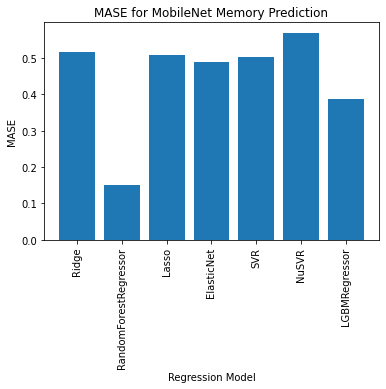

In [28]:
bar_plot(mobilenet_mem_results, 'MASE for MobileNet Memory Prediction', 'Regression Model', 'MASE')

In [24]:
bar_plot(mobilenet_mem_results, 'MASE for MobileNet Memory Prediction', 'Regression Model', 'MASE')

0                    Ridge
1    RandomForestRegressor
2                    Lasso
3               ElasticNet
4                      SVR
5                    NuSVR
6            LGBMRegressor
Name: Model, dtype: object

In [30]:
# New models

inception_resnet = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=True, weights="imagenet",
)
nasnet = tf.keras.applications.nasnet.NASNetLarge(include_top=True, weights="imagenet",)

inception_resnet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), inception_resnet)
nasnet_cpu_eval = cnn_cpu_reg.compare(get_regressors(), nasnet)
vgg16_cpu_eval = cnn_cpu_reg.compare(get_regressors(), vgg16)
inception_cpu_eval = cnn_cpu_reg.compare(get_regressors(), inception)

inception_resnet_mem_eval = cnn_mem_reg.compare(get_regressors(), inception_resnet)
nasnet_mem_eval = cnn_mem_reg.compare(get_regressors(), nasnet)
vgg16_mem_eval = cnn_mem_reg.compare(get_regressors(), vgg16)
inception_mem_eval = cnn_mem_reg.compare(get_regressors(), inception)

Comparing regression models for inception_resnet_v2 RegressorType.CPU
                   Model       MSE      MASE
0                  Ridge  0.378908  0.550126
1  RandomForestRegressor  0.185508  0.320318
2                  Lasso  0.398070  0.517213
3             ElasticNet  0.329631  0.495941
4                    SVR  0.278131  0.409152
5                  NuSVR  0.265004  0.408983
6          LGBMRegressor  0.581622  0.944189
Comparing regression models for NASNet RegressorType.CPU
                   Model        MSE      MASE
0                  Ridge   3.856469  2.229436
1  RandomForestRegressor   3.043236  1.915698
2                  Lasso   5.105832  2.178743
3             ElasticNet   4.877508  2.128623
4                    SVR   1.249670  1.131903
5                  NuSVR   1.261558  1.144216
6          LGBMRegressor  22.407990  4.341015
Comparing regression models for vgg16 RegressorType.CPU
                   Model         MSE       MASE
0                  Ridge   76.994995   9.

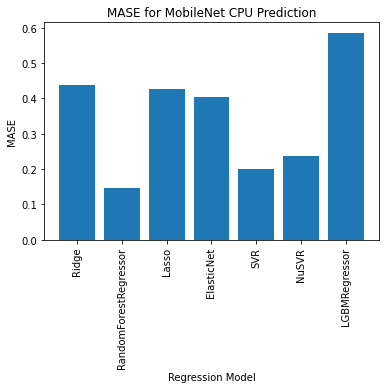

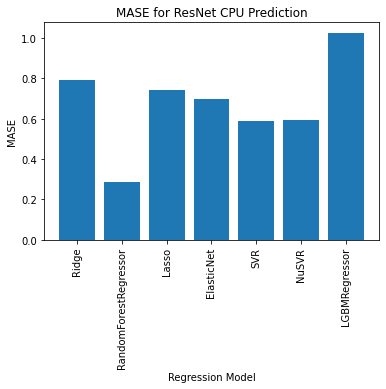

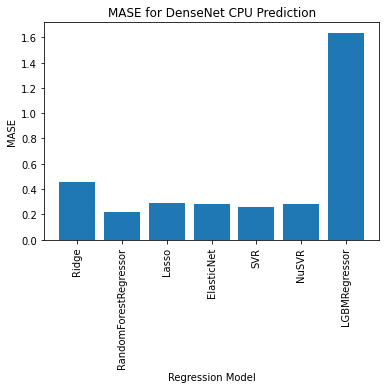

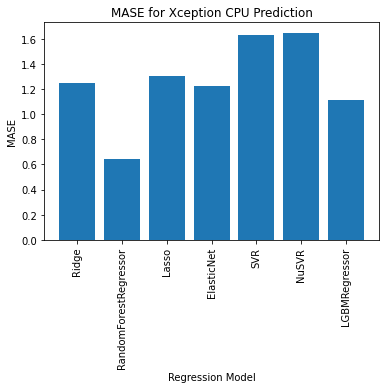

In [48]:
bar_plot(mobilenet_cpu_eval, 'MASE for MobileNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(resnet_cpu_eval, 'MASE for ResNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(densenet_cpu_eval, 'MASE for DenseNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(xception_cpu_eval, 'MASE for Xception CPU Prediction', 'Regression Model', 'MASE')
bar_plot(vgg16_cpu_eval, 'MASE for VGG16 CPU Prediction', 'Regression Model', 'MASE')
bar_plot(inception_cpu_eval, 'MASE for Inception CPU Prediction', 'Regression Model', 'MASE')

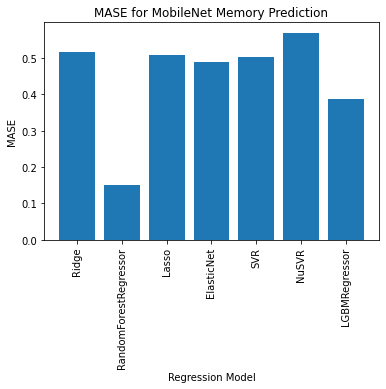

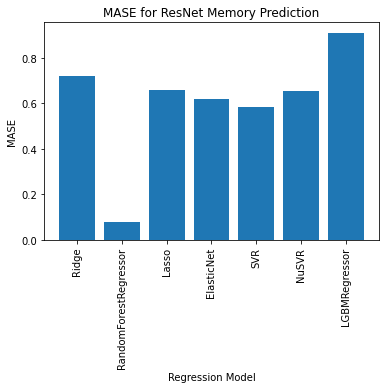

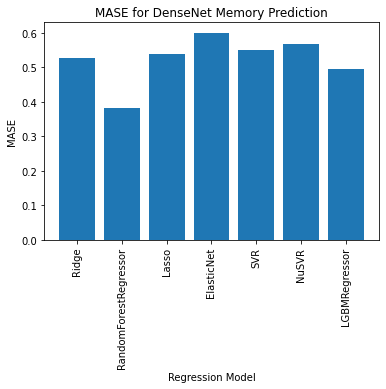

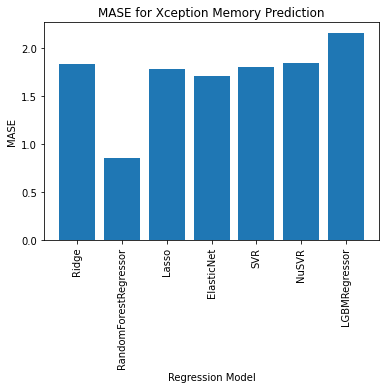

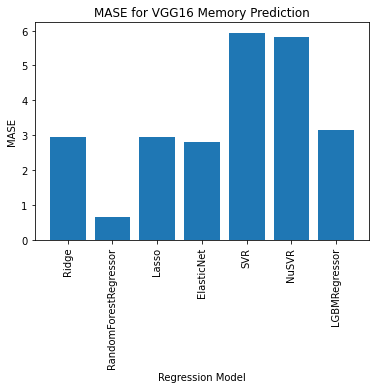

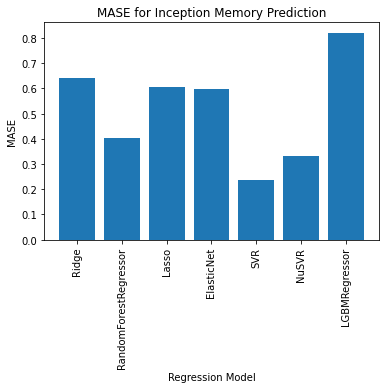

In [57]:
bar_plot(mobilenet_mem_eval, 'MASE for MobileNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(resnet_mem_eval, 'MASE for ResNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(densenet_mem_eval, 'MASE for DenseNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(xception_mem_eval, 'MASE for Xception Memory Prediction', 'Regression Model', 'MASE')
bar_plot(vgg16_mem_eval, 'MASE for VGG16 Memory Prediction', 'Regression Model', 'MASE')
bar_plot(inception_mem_eval, 'MASE for Inception Memory Prediction', 'Regression Model', 'MASE')

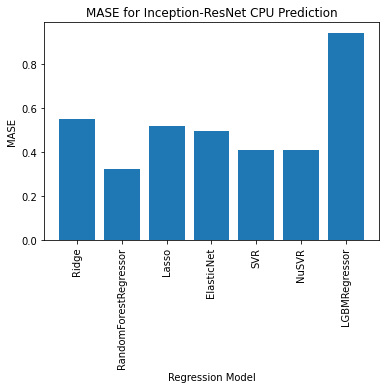

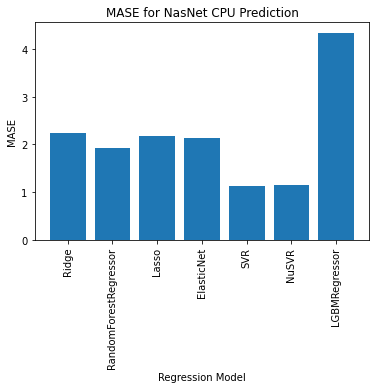

In [55]:
bar_plot(inception_resnet_cpu_eval, 'MASE for Inception-ResNet CPU Prediction', 'Regression Model', 'MASE')
bar_plot(nasnet_cpu_eval, 'MASE for NasNet CPU Prediction', 'Regression Model', 'MASE')


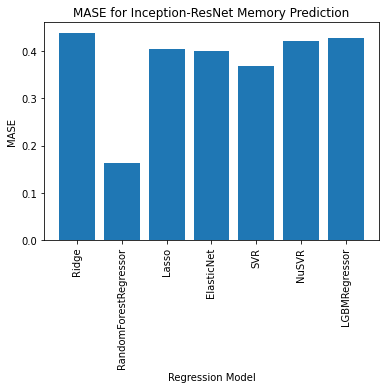

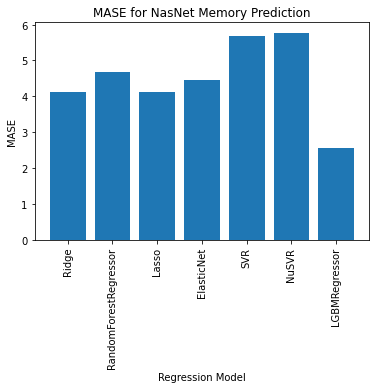

In [56]:
bar_plot(inception_resnet_mem_eval, 'MASE for Inception-ResNet Memory Prediction', 'Regression Model', 'MASE')
bar_plot(nasnet_mem_eval, 'MASE for NasNet Memory Prediction', 'Regression Model', 'MASE')
